In [2704]:
import importlib
import utils
import transformers
import models
import losses

In [2705]:
from models import *
from utils import *

In [2706]:
importlib.reload(utils)
importlib.reload(transformers)
importlib.reload(models)
importlib.reload(losses)

<module 'losses' from 'd:\\Documents\\machinelearning\\cgm-paper\\src\\losses.py'>

In [2707]:
print("Current working directory: ", os.getcwd())

Current working directory:  d:\Documents\machinelearning\cgm-paper\src


In [2708]:
raw_dir = "../data/raw"
tuning_dir = "../data/tuning"

In [2709]:
assert os.path.exists(raw_dir), "Raw data directory not found"
assert os.path.exists(tuning_dir), "Tuning data directory not found"

In [2710]:
dataset = load_data(raw_dir)

Found 22 files in ../data/raw
train (139415, 47)
test (32912, 47)


In [2711]:
val_dataset = load_data(tuning_dir)

Found 2 files in ../data/tuning
train (13630, 43)
test (3002, 43)


In [2712]:
for key in dataset.keys():
    val_dataset[key] = reduce_classes(val_dataset[key])
    dataset[key] = reduce_classes(dataset[key])

In [2713]:
dataset.get("train")['Time'].isnull().sum()

0

In [2714]:
train_data = get_train_dataset(dataset['train'])
test_data = get_any_dataset(dataset['test'], dataset['train'])

      CGM  month  day  hour  minute  weekday  year  cgm_velo  CGM(1)  CGM(2)  \
6    71.0      5   19    12       5        2  2027  0.010000    66.0    64.5   
7    78.0      5   19    12      10        2  2027  0.016667    71.0    68.5   
8    90.0      5   19    12      15        2  2027  0.023333    78.0    74.5   
9    99.0      5   19    12      20        2  2027  0.040000    90.0    84.0   
10  110.0      5   19    12      25        2  2027  0.030000    99.0    94.5   

       CGM(3)  CGM(4)  CGM(5)     CGM(6)  
6   64.666667   65.50    66.8  68.333333  
7   66.666667   66.25    66.6  67.500000  
8   71.666667   69.50    68.6  68.500000  
9   79.666667   76.25    73.6  72.166667  
10  89.000000   84.50    80.8  77.833333  


The tuning data will be merged with the training data and be fitted into the pipeline to be used for the validation data

In [2715]:
tuning_data = get_tuning_dataset(val_dataset['train'], dataset['train'])
val_data = get_any_dataset(val_dataset['test'], tuning_data)

In [2716]:
models = Models()

In [2717]:
trainX, trainY = train_data.drop(["CGM"], axis = 1), train_data["CGM"]
trainX.shape, trainY.shape

((123697, 13), (123697,))

In [2718]:
testX, testY = test_data.drop(["CGM"], axis = 1), test_data["CGM"]
testX.shape, testY.shape

((28455, 13), (28455,))

In [2719]:
models.fit(trainX, trainY, testX, testY)

 50%|█████     | 1/2 [00:00<00:00,  4.55it/s]

XGBoost MSE: 21.51547536159897, RMSE: 4.638477698728212, MSPE: 0.08906777857048373 %


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

LightGBM MSE: 18.87707479282781, RMSE: 4.344775574506445, MSPE: 0.08473398002636034 %


,pred
0,229.636082
1,224.727580
2,219.627969
3,216.462320
4,213.385734
...,...
28450,148.209496
28451,147.706847
28452,146.560511
28453,154.163890


In [2720]:
N = 3

In [2721]:
forecastX, forecastY = testX.iloc[:N], testY.iloc[N-1:N*2-1]

In [2722]:
testX.reset_index(drop = True, inplace = True)

In [2723]:
testset = testX.copy()
testset.loc[:, "truth"] = testY

In [2724]:
best_preds = models.fit(trainX, trainY, testX, testY)
best_preds["truth"] = testY

 50%|█████     | 1/2 [00:00<00:00,  3.41it/s]

XGBoost MSE: 21.51547536159897, RMSE: 4.638477698728212, MSPE: 0.08906777857048373 %


100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

LightGBM MSE: 18.87707479282781, RMSE: 4.344775574506445, MSPE: 0.08473398002636034 %


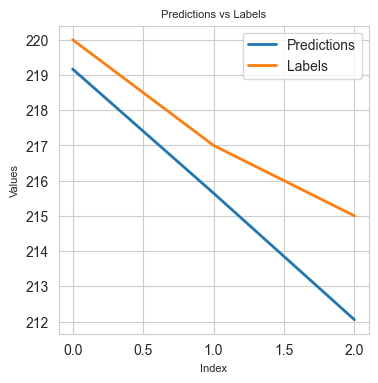

XGBoost MSE: 3.7410838357172906, RMSE: 1.9341881593364412, MSPE: nan %


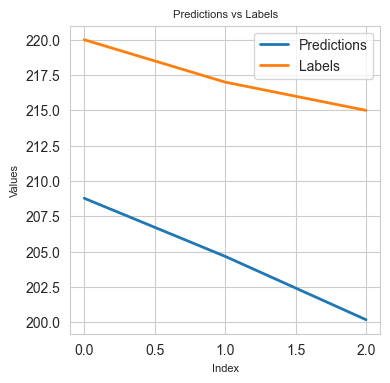

LightGBM MSE: 165.80310707667618, RMSE: 12.876455532353466, MSPE: nan %


In [2725]:
forecasts = models.forecast(forecastX, forecastY, N)